In [1]:
import skimage
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import time
import argparse
import cv2
from scipy import io
from tqdm.notebook import tqdm

import torch
from torch import nn
import torch.nn.functional as F
import torchvision.models as models
import torch.optim.lr_scheduler as lr_scheduler
from pytorch_msssim import ssim

from modules import utils
from modules.models import INR

In [4]:
parser = argparse.ArgumentParser(description='STAF super resolution')

# Shared Parameters
parser.add_argument('--input',type=str, default='./data/Image/0882.png', help='Input image path')
parser.add_argument('--inr_model',type=str, default='staf', help='[gauss, mfn, relu, siren, wire, wire2d, ffn, incode, finer, staf]')
parser.add_argument('--lr',type=float, default=1e-3, help='Learning rate')
parser.add_argument('--using_schedular', type=bool, default=True, help='Whether to use schedular')
parser.add_argument('--scheduler_b', type=float, default=0.1, help='Learning rate scheduler')
parser.add_argument('--maxpoints', type=int, default=16*16, help='Batch size')
parser.add_argument('--niters', type=int, default=501, help='Number if iterations')
parser.add_argument('--steps_til_summary', type=int, default=100, help='Number of steps till summary visualization')
parser.add_argument('--upscale_factor', type=int, default=4, help='Upscale factor for super-resolution (e.g., 4x larger output)')
parser.add_argument('--eval_epoch', type=int, default=400, help='HR evaluation epoch')

# INCODE Parameters
parser.add_argument('--a_coef',type=float, default=0.1993, help='a coeficient')
parser.add_argument('--b_coef',type=float, default=0.0196, help='b coeficient')
parser.add_argument('--c_coef',type=float, default=0.0588, help='c coeficient')
parser.add_argument('--d_coef',type=float, default=0.0269, help='d coeficient')


args = parser.parse_args(args=[])

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Loading Data

In [9]:
im_hr = utils.normalize(plt.imread(args.input).astype(np.float32), True)
im_lr = cv2.resize(im_hr, None, fx=1/args.upscale_factor, fy=1/args.upscale_factor, interpolation=cv2.INTER_AREA)
H_hr, W_hr, _ = im_hr.shape
H_lr, W_lr, _ = im_lr.shape

print(f'image hr: {H_hr}, {W_hr}')
print(f'image lr: {H_lr}, {W_lr}')

image hr: 1356, 2040
image lr: 339, 510


## Defining Model

### Defining desired Positional Encoding

In [10]:
# Frequency Encoding
pos_encode_freq = {'type':'frequency', 'use_nyquist': True, 'mapping_input': int(max(H_lr, W_lr))}

# Gaussian Encoding
pos_encode_gaus = {'type':'gaussian', 'scale_B': 10, 'mapping_input': 256}

# No Encoding
pos_encode_no = {'type': None}

### Model Configureations

In [11]:
### Model Configurations for STAF
model = INR(args.inr_model).run(in_features=2,
                                out_features=3,
                                hidden_features=256,
                                hidden_layers=3,
                                first_omega_0=30.0,
                                hidden_omega_0=30.0
                               ).to(device)


if args.inr_model == 'incode':
    ### INCODE Harmonizer Configurations
    MLP_configs={'task': 'image',
                 'model': 'resnet34',
                 'truncated_layer':5,
                 'in_channels': 64,
                 'hidden_channels': [64, 32, 4],
                 'mlp_bias':0.3120,
                 'activation_layer': nn.SiLU,
                 'GT': torch.tensor(im_lr).to(device)[None,...].permute(0, 3, 1, 2)
                }
    
    ### Model Configurations
    model = INR(args.inr_model).run(in_features=2,
                                    out_features=3,
                                    hidden_features=256,
                                    hidden_layers=3,
                                    first_omega_0=30.0,
                                    hidden_omega_0=30.0,
                                    pos_encode_configs=pos_encode_no,
                                    MLP_configs = MLP_configs
                                   ).to(device)
elif args.inr_model == 'finer':
    model = INR(args.inr_model).run(in_features=2,
                                out_features=3, 
                                hidden_features=256,
                                hidden_layers=3,
                                first_omega_0=30.0,
                                hidden_omega_0=30.0,
                                first_bias_scale=5.0,
                               ).to(device)

else:
    ### Model Configurations
    model = INR(args.inr_model).run(in_features=2,
                                    out_features=3,
                                    hidden_features=256,
                                    hidden_layers=3,
                                    first_omega_0=30.0,
                                    hidden_omega_0=30.0
                                   ).to(device)

## Training Code

In [12]:
# Optimizer setup
if args.inr_model == 'wire':
    args.lr = args.lr * min(1, args.maxpoints / (H * W))
optim = torch.optim.Adam(lr=args.lr, params=model.parameters())
scheduler = lr_scheduler.LambdaLR(optim, lambda x: args.scheduler_b ** min(x / args.niters, 1))

# Initialize lists for PSNR and SSIM
psnr_values_lr = []
psnr_values_hr = []
ssim_values_hr = []
mse_array = torch.zeros(args.niters, device=device)

# Initialize best loss value as positive infinity
best_loss = torch.tensor(float('inf'))

# Generate coordinate grid
coords_lr = utils.get_coords(H_lr, W_lr, dim=2)[None, ...]
coords_hr = utils.get_coords(H_hr, W_hr, dim=2)[None, ...]

# Convert input image to a tensor and reshape
gt_lr = torch.tensor(im_lr).reshape(H_lr * W_lr, 3)[None, ...].to(device)
gt_hr = torch.tensor(im_hr).reshape(H_hr * W_hr, 3)[None, ...].to(device)

# Initialize a tensor for reconstructed data
rec_lr = torch.zeros_like(gt_lr)
rec_hr = torch.zeros_like(gt_hr)

  0%|          | 0/501 [00:00<?, ?it/s]

Epoch: 0 | Total Loss: 0.02379 | PSNR LR: 16.2368
Epoch: 100 | Total Loss: 0.00106 | PSNR LR: 29.7446
Epoch: 200 | Total Loss: 0.00039 | PSNR LR: 34.0407
Epoch: 300 | Total Loss: 0.00021 | PSNR LR: 36.7289
Epoch: 400 | Total Loss: 0.00011 | PSNR LR: 39.5217


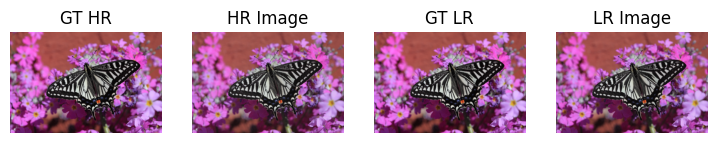

Epoch: 401 | Total Loss: 0.00011 | PSNR LR: 39.5514 | PSNR HR: 29.9797 | SSIM: 0.9012


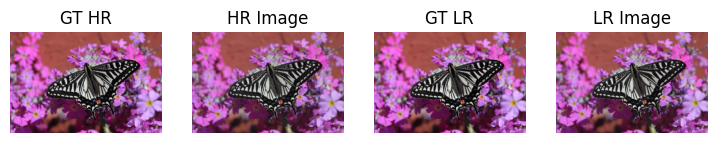

Epoch: 402 | Total Loss: 0.00011 | PSNR LR: 39.7531 | PSNR HR: 29.9849 | SSIM: 0.9013


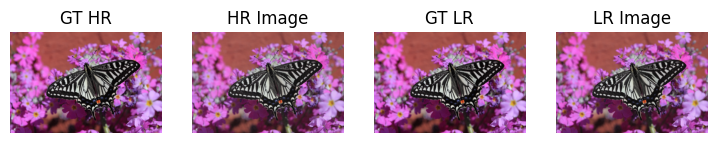

Epoch: 403 | Total Loss: 0.00011 | PSNR LR: 39.6190 | PSNR HR: 30.0748 | SSIM: 0.8950


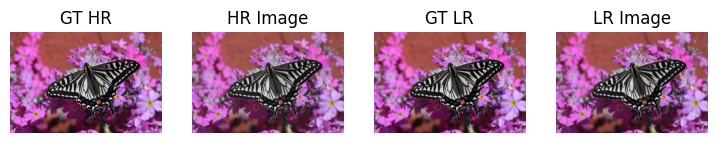

Epoch: 404 | Total Loss: 0.00010 | PSNR LR: 39.7928 | PSNR HR: 30.2364 | SSIM: 0.9009
Epoch: 405 | Total Loss: 0.00010 | PSNR LR: 40.0239 | PSNR HR: 30.1955 | SSIM: 0.9001
Epoch: 406 | Total Loss: 0.00010 | PSNR LR: 39.8658 | PSNR HR: 29.9839 | SSIM: 0.9011
Epoch: 407 | Total Loss: 0.00010 | PSNR LR: 40.0148 | PSNR HR: 30.0376 | SSIM: 0.8920
Epoch: 408 | Total Loss: 0.00010 | PSNR LR: 39.8990 | PSNR HR: 30.0526 | SSIM: 0.8975
Epoch: 409 | Total Loss: 0.00010 | PSNR LR: 39.8148 | PSNR HR: 30.1421 | SSIM: 0.9003
Epoch: 410 | Total Loss: 0.00010 | PSNR LR: 39.9376 | PSNR HR: 30.0216 | SSIM: 0.8977


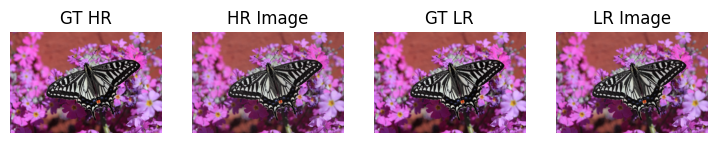

Epoch: 411 | Total Loss: 0.00010 | PSNR LR: 39.8605 | PSNR HR: 30.2492 | SSIM: 0.9054
Epoch: 412 | Total Loss: 0.00010 | PSNR LR: 39.8274 | PSNR HR: 30.0792 | SSIM: 0.9005
Epoch: 413 | Total Loss: 0.00010 | PSNR LR: 40.0827 | PSNR HR: 30.2222 | SSIM: 0.8971
Epoch: 414 | Total Loss: 0.00010 | PSNR LR: 40.0164 | PSNR HR: 29.9046 | SSIM: 0.8976
Epoch: 415 | Total Loss: 0.00010 | PSNR LR: 40.0905 | PSNR HR: 30.1679 | SSIM: 0.8992
Epoch: 416 | Total Loss: 0.00010 | PSNR LR: 40.1199 | PSNR HR: 30.1080 | SSIM: 0.9016
Epoch: 417 | Total Loss: 0.00010 | PSNR LR: 40.0722 | PSNR HR: 29.9252 | SSIM: 0.9008
Epoch: 418 | Total Loss: 0.00010 | PSNR LR: 40.1084 | PSNR HR: 30.2054 | SSIM: 0.8999
Epoch: 419 | Total Loss: 0.00010 | PSNR LR: 40.0321 | PSNR HR: 30.0614 | SSIM: 0.8999


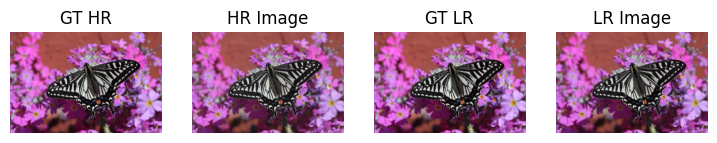

Epoch: 420 | Total Loss: 0.00010 | PSNR LR: 40.2047 | PSNR HR: 30.3007 | SSIM: 0.8994


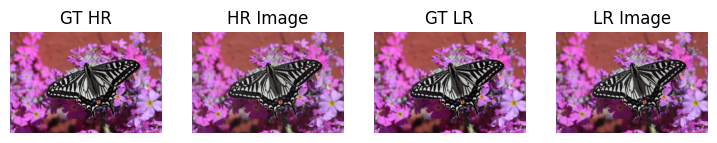

Epoch: 421 | Total Loss: 0.00009 | PSNR LR: 40.2755 | PSNR HR: 30.3239 | SSIM: 0.9029
Epoch: 422 | Total Loss: 0.00010 | PSNR LR: 40.1643 | PSNR HR: 30.2761 | SSIM: 0.9024
Epoch: 423 | Total Loss: 0.00010 | PSNR LR: 40.1844 | PSNR HR: 30.0137 | SSIM: 0.8946
Epoch: 424 | Total Loss: 0.00009 | PSNR LR: 40.3604 | PSNR HR: 30.1818 | SSIM: 0.9020
Epoch: 425 | Total Loss: 0.00009 | PSNR LR: 40.4062 | PSNR HR: 30.0382 | SSIM: 0.8950
Epoch: 426 | Total Loss: 0.00009 | PSNR LR: 40.2261 | PSNR HR: 30.1222 | SSIM: 0.8990
Epoch: 427 | Total Loss: 0.00009 | PSNR LR: 40.4278 | PSNR HR: 30.1122 | SSIM: 0.9002
Epoch: 428 | Total Loss: 0.00009 | PSNR LR: 40.3726 | PSNR HR: 30.2731 | SSIM: 0.8980


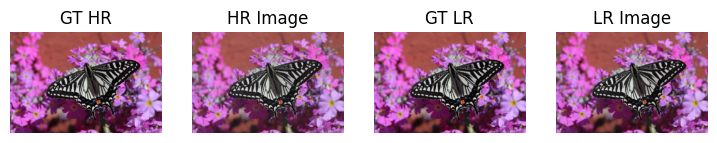

Epoch: 429 | Total Loss: 0.00009 | PSNR LR: 40.4682 | PSNR HR: 30.3533 | SSIM: 0.8936
Epoch: 430 | Total Loss: 0.00009 | PSNR LR: 40.5095 | PSNR HR: 30.2377 | SSIM: 0.8974
Epoch: 431 | Total Loss: 0.00009 | PSNR LR: 40.3783 | PSNR HR: 30.3008 | SSIM: 0.9028
Epoch: 432 | Total Loss: 0.00009 | PSNR LR: 40.5224 | PSNR HR: 30.2846 | SSIM: 0.8985
Epoch: 433 | Total Loss: 0.00009 | PSNR LR: 40.2552 | PSNR HR: 30.1766 | SSIM: 0.8964
Epoch: 434 | Total Loss: 0.00009 | PSNR LR: 40.4056 | PSNR HR: 30.2389 | SSIM: 0.8986
Epoch: 435 | Total Loss: 0.00009 | PSNR LR: 40.6687 | PSNR HR: 30.2068 | SSIM: 0.9011
Epoch: 436 | Total Loss: 0.00009 | PSNR LR: 40.6284 | PSNR HR: 30.1762 | SSIM: 0.9022
Epoch: 437 | Total Loss: 0.00009 | PSNR LR: 40.5208 | PSNR HR: 30.2476 | SSIM: 0.8991
Epoch: 438 | Total Loss: 0.00009 | PSNR LR: 40.6505 | PSNR HR: 30.1536 | SSIM: 0.9025
Epoch: 439 | Total Loss: 0.00009 | PSNR LR: 40.5101 | PSNR HR: 30.1999 | SSIM: 0.9057
Epoch: 440 | Total Loss: 0.00009 | PSNR LR: 40.6196 | 

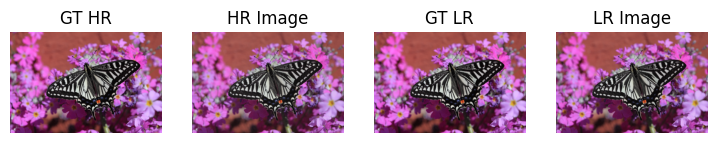

Epoch: 445 | Total Loss: 0.00009 | PSNR LR: 40.6649 | PSNR HR: 30.3667 | SSIM: 0.9026
Epoch: 446 | Total Loss: 0.00008 | PSNR LR: 40.9053 | PSNR HR: 30.3487 | SSIM: 0.9012
Epoch: 447 | Total Loss: 0.00009 | PSNR LR: 40.7020 | PSNR HR: 30.2777 | SSIM: 0.9029
Epoch: 448 | Total Loss: 0.00008 | PSNR LR: 40.8011 | PSNR HR: 30.0660 | SSIM: 0.8996
Epoch: 449 | Total Loss: 0.00008 | PSNR LR: 40.9749 | PSNR HR: 30.1827 | SSIM: 0.9011
Epoch: 450 | Total Loss: 0.00008 | PSNR LR: 40.7902 | PSNR HR: 30.2393 | SSIM: 0.8942
Epoch: 451 | Total Loss: 0.00008 | PSNR LR: 40.8857 | PSNR HR: 30.3263 | SSIM: 0.8972
Epoch: 452 | Total Loss: 0.00008 | PSNR LR: 40.9056 | PSNR HR: 30.2259 | SSIM: 0.8965
Epoch: 453 | Total Loss: 0.00008 | PSNR LR: 40.9061 | PSNR HR: 30.2021 | SSIM: 0.8934
Epoch: 454 | Total Loss: 0.00008 | PSNR LR: 41.0900 | PSNR HR: 30.2500 | SSIM: 0.9030
Epoch: 455 | Total Loss: 0.00008 | PSNR LR: 41.0323 | PSNR HR: 30.2181 | SSIM: 0.8943
Epoch: 456 | Total Loss: 0.00008 | PSNR LR: 40.9612 | 

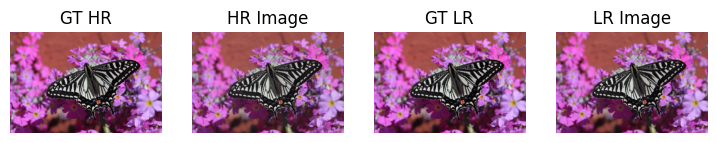

Epoch: 467 | Total Loss: 0.00008 | PSNR LR: 41.2295 | PSNR HR: 30.3770 | SSIM: 0.9018
Epoch: 468 | Total Loss: 0.00007 | PSNR LR: 41.2744 | PSNR HR: 30.3249 | SSIM: 0.8959
Epoch: 469 | Total Loss: 0.00007 | PSNR LR: 41.3183 | PSNR HR: 30.3571 | SSIM: 0.8970
Epoch: 470 | Total Loss: 0.00008 | PSNR LR: 41.1393 | PSNR HR: 30.1931 | SSIM: 0.8984
Epoch: 471 | Total Loss: 0.00007 | PSNR LR: 41.3546 | PSNR HR: 30.2149 | SSIM: 0.8961
Epoch: 472 | Total Loss: 0.00007 | PSNR LR: 41.3951 | PSNR HR: 30.1675 | SSIM: 0.8962


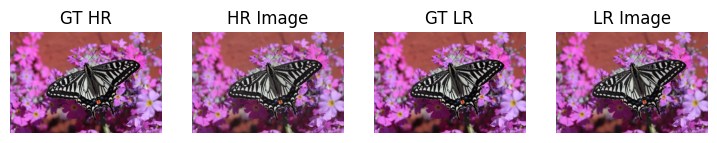

Epoch: 473 | Total Loss: 0.00007 | PSNR LR: 41.4450 | PSNR HR: 30.4485 | SSIM: 0.8989
Epoch: 474 | Total Loss: 0.00007 | PSNR LR: 41.3378 | PSNR HR: 30.1998 | SSIM: 0.8978
Epoch: 475 | Total Loss: 0.00007 | PSNR LR: 41.4393 | PSNR HR: 30.2207 | SSIM: 0.9013
Epoch: 476 | Total Loss: 0.00007 | PSNR LR: 41.5160 | PSNR HR: 30.4143 | SSIM: 0.8989
Epoch: 477 | Total Loss: 0.00007 | PSNR LR: 41.4018 | PSNR HR: 30.2824 | SSIM: 0.9021
Epoch: 478 | Total Loss: 0.00007 | PSNR LR: 41.5571 | PSNR HR: 30.4093 | SSIM: 0.9013
Epoch: 479 | Total Loss: 0.00007 | PSNR LR: 41.5015 | PSNR HR: 30.3143 | SSIM: 0.8985
Epoch: 480 | Total Loss: 0.00007 | PSNR LR: 41.4184 | PSNR HR: 30.2252 | SSIM: 0.8978
Epoch: 481 | Total Loss: 0.00007 | PSNR LR: 41.3103 | PSNR HR: 30.1304 | SSIM: 0.8985
Epoch: 482 | Total Loss: 0.00007 | PSNR LR: 41.6530 | PSNR HR: 30.1287 | SSIM: 0.9010
Epoch: 483 | Total Loss: 0.00007 | PSNR LR: 41.5416 | PSNR HR: 30.1939 | SSIM: 0.8952
Epoch: 484 | Total Loss: 0.00007 | PSNR LR: 41.5187 | 

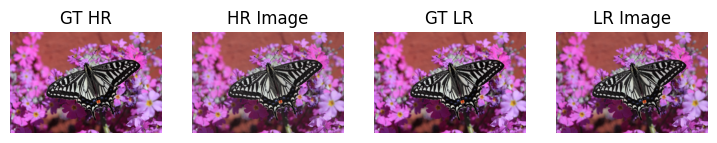

Epoch: 487 | Total Loss: 0.00007 | PSNR LR: 41.6909 | PSNR HR: 30.4989 | SSIM: 0.8987
Epoch: 488 | Total Loss: 0.00007 | PSNR LR: 41.6528 | PSNR HR: 30.3370 | SSIM: 0.8974
Epoch: 489 | Total Loss: 0.00007 | PSNR LR: 41.5813 | PSNR HR: 30.3934 | SSIM: 0.8997
Epoch: 490 | Total Loss: 0.00007 | PSNR LR: 41.7503 | PSNR HR: 30.3553 | SSIM: 0.8990
Epoch: 491 | Total Loss: 0.00007 | PSNR LR: 41.8219 | PSNR HR: 30.3351 | SSIM: 0.8963
Epoch: 492 | Total Loss: 0.00007 | PSNR LR: 41.7945 | PSNR HR: 30.3177 | SSIM: 0.8974
Epoch: 493 | Total Loss: 0.00007 | PSNR LR: 41.7171 | PSNR HR: 30.2730 | SSIM: 0.9014
Epoch: 494 | Total Loss: 0.00007 | PSNR LR: 41.7983 | PSNR HR: 30.2046 | SSIM: 0.8986
Epoch: 495 | Total Loss: 0.00007 | PSNR LR: 41.7015 | PSNR HR: 30.3843 | SSIM: 0.8980
Epoch: 496 | Total Loss: 0.00006 | PSNR LR: 41.9382 | PSNR HR: 30.3865 | SSIM: 0.8983
Epoch: 497 | Total Loss: 0.00006 | PSNR LR: 41.8899 | PSNR HR: 30.3027 | SSIM: 0.9023
Epoch: 498 | Total Loss: 0.00006 | PSNR LR: 41.9163 | 

In [13]:
for step in tqdm(range(args.niters)):
    # Randomize the order of data points for each iteration
    indices = torch.randperm(H_lr*W_lr)

    # Process data points in batches
    for b_idx in range(0, H_lr*W_lr, args.maxpoints):
        b_indices = indices[b_idx:min(H_lr*W_lr, b_idx+args.maxpoints)]
        b_coords = coords_lr[:, b_indices, ...].to(device)
        b_indices = b_indices.to(device)

        # Calculate model output
        if args.inr_model == 'incode':
            model_output, coef = model(b_coords)
        else:
            model_output = model(b_coords)

        # Update the reconstructed data
        with torch.no_grad():
            rec_lr[:, b_indices, :] = model_output

        # Calculate the output loss
        output_loss = ((model_output - gt_lr[:, b_indices, :])**2).mean()

        if args.inr_model == 'incode':
            # Calculate regularization loss for 'incode' model
            a_coef, b_coef, c_coef, d_coef = coef[0]
            reg_loss = args.a_coef * torch.relu(-a_coef) + \
                       args.b_coef * torch.relu(-b_coef) + \
                       args.c_coef * torch.relu(-c_coef) + \
                       args.d_coef * torch.relu(-d_coef)

            # Total loss for 'incode' model
            loss = output_loss + reg_loss
        else:
            # Total loss for other models
            loss = output_loss

        # Perform backpropagation and update model parameters
        optim.zero_grad()
        loss.backward()
        optim.step()


    # Calculate and log mean squared error (MSE) and PSNR
    with torch.no_grad():
        mse_array[step] = ((gt_lr - rec_lr)**2).mean().item()
        psnr_lr = -10*torch.log10(mse_array[step])
        psnr_values_lr.append(psnr_lr.item())

        #### HR Evaluation
        if step > args.eval_epoch:
            indices_hr = torch.randperm(H_hr*W_hr)
            for b_idx in range(0, H_hr*W_hr, args.maxpoints):
                b_indices_hr = indices_hr[b_idx:min(H_hr*W_hr, b_idx+args.maxpoints)]
                b_coords_hr = coords_hr[:, b_indices_hr, ...].to(device)
                b_indices_hr = b_indices_hr.to(device)

                if args.inr_model == 'incode':
                    model_eval, _ = model(b_coords_hr)
                else:
                    model_eval = model(b_coords_hr)

                rec_hr[:, b_indices_hr, :] = model_eval

            loss_hr = ((gt_hr - rec_hr)**2).mean()
            psnr_hr = -10*torch.log10(loss_hr)
            psnr_values_hr.append(psnr_hr.item())
            hr_pred = rec_hr[0, ...].reshape(H_hr, W_hr, 3).detach().cpu().numpy()
            hr_pred = (hr_pred - hr_pred.min()) / (hr_pred.max() - hr_pred.min())

            # Check if the current iteration's HR image is the best so far
            if (loss_hr < best_loss) or (step == args.eval_epoch+1):
                best_loss = loss_hr
                best_img_hr = hr_pred
                best_img_lr = rec_lr[0, ...].reshape(H_lr, W_lr, 3).detach().cpu().numpy()
                best_img_lr = (best_img_lr - best_img_lr.min()) / (best_img_lr.max() - best_img_lr.min())

                ### Plot
                fig, axes = plt.subplots(1, 4, figsize=(9, 9))
                subplot_info = [
                    {'title': 'GT HR', 'image': im_hr},
                    {'title': 'HR Image', 'image': best_img_hr},
                    {'title': 'GT LR', 'image': im_lr},
                    {'title': 'LR Image', 'image': best_img_lr}
                ]

                for ax, info in zip(axes, subplot_info):
                    ax.set_title(info['title'])
                    ax.imshow(info['image'], cmap='gray')
                    ax.axis('off')
                plt.show()


              # SSIM
            ms_ssim_val = ssim(torch.tensor(im_hr[None,...]).permute(0, 3, 1, 2),
                                torch.tensor(hr_pred[None, ...]).permute(0, 3, 1, 2),
                                data_range=1, size_average=False)
            ssim_values_hr.append(ms_ssim_val[0].item())

            # Display intermediate results at specified intervals
            print("Epoch: {} | Total Loss: {:.5f} | PSNR LR: {:.4f} | PSNR HR: {:.4f} | SSIM: {:.4f}".format(step,
                                                                                                  mse_array[step].item(),
                                                                                                  psnr_lr.item(),
                                                                                                  psnr_hr.item(),
                                                                                                  ms_ssim_val[0].item()))

        # Display intermediate results at specified intervals
        if (step % args.steps_til_summary == 0) and step <= args.eval_epoch:
            print("Epoch: {} | Total Loss: {:.5f} | PSNR LR: {:.4f}".format(step,
                                                                             mse_array[step].item(),
                                                                             psnr_lr.item()))

    # Adjust learning rate using a sch.duler if applicable
    if args.using_schedular:
        scheduler.step()


# Print maximum PSNR achieved during training
print('--------------------')
print('Max PSNR LR:', max(psnr_values_lr))
print('Max PSNR HR:', max(psnr_values_hr))
print('--------------------')

# Convergance Rate

findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times Ne

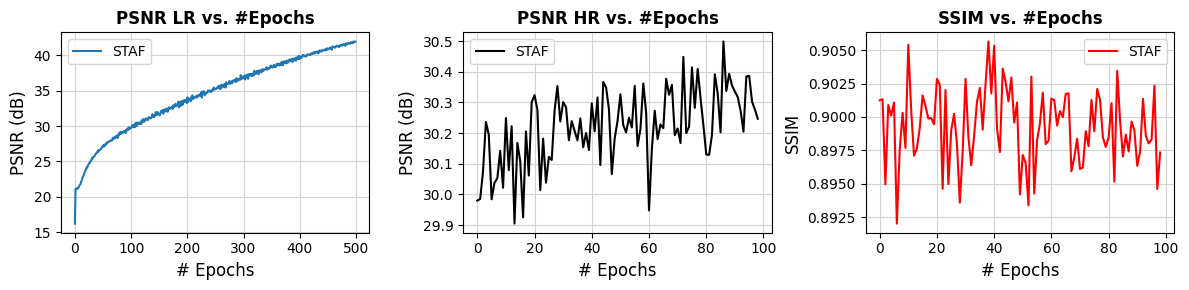

In [15]:
## PSNR LR vs. #Epochs
## PSNR HR vs. #Epochs
## SSIM vs. #Epochs


# Define the font settings
font = {'font': 'Times New Roman', 'size': 12}
axfont = {'family': 'Times New Roman', 'weight': 'regular', 'size': 10}

# Create a figure with 3 subplots
fig, axes = plt.subplots(1, 3, figsize=(12, 3))

# Plot PSNR LR vs. #Epochs
axes[0].plot(np.arange(len(psnr_values_lr[:-1])), psnr_values_lr[:-1], label=f"{(args.inr_model).upper()}")
axes[0].set_xlabel('# Epochs', fontdict=font)
axes[0].set_ylabel('PSNR (dB)', fontdict=font)
axes[0].set_title('PSNR LR vs. #Epochs', fontdict={'family': 'Times New Roman', 'size': 12, 'weight': 'bold'})
axes[0].legend()
axes[0].grid(True, color='lightgray')

# Plot PSNR HR vs. #Epochs
axes[1].plot(np.arange(len(psnr_values_hr[:-1])), psnr_values_hr[:-1], label=f"{(args.inr_model).upper()}", color='black')
axes[1].set_xlabel('# Epochs', fontdict=font)
axes[1].set_ylabel('PSNR (dB)', fontdict=font)
axes[1].set_title('PSNR HR vs. #Epochs', fontdict={'family': 'Times New Roman', 'size': 12, 'weight': 'bold'})
axes[1].legend()
axes[1].grid(True, color='lightgray')

# Plot SSIM vs. #Epochs
axes[2].plot(np.arange(len(ssim_values_hr[:-1])), ssim_values_hr[:-1], label=f"{(args.inr_model).upper()}", color='red')
axes[2].set_xlabel('# Epochs', fontdict=font)
axes[2].set_ylabel('SSIM', fontdict=font)
axes[2].set_title('SSIM vs. #Epochs', fontdict={'family': 'Times New Roman', 'size': 12, 'weight': 'bold'})
axes[2].legend()
axes[2].grid(True, color='lightgray')

# Adjust spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()